In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from scipy import signal

from IPython.display import display, Markdown

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Position and Direction Estimation using Cross-Correlation of Signals between Distant Nodes

Accuracy of TDoA estimation of position and signal AoA are explored in this notebook using a simulated RF channel.

Using cheap of the shelf radios such as the CC1352 we can get access to raw IQ samples to do more interesting analysis of the RF data than was previously possible with previous generations of chips which contained fully closed modems which only provided the demodulated data.  This raw data can be used with syncronization signals to estimate the position of other RF devices in the enviornment to an accuracy of 10's of meters.  In particular using the low bit rate long range (900Mhz) modes of these devices several devices spaced ~1km can locate other transmitters in the envorment to an accuracy of ~10m.

TODO:
* Clock Jitter simulation
* Simulate Syncronization Mechanism with clock jitter
* Simulate noise in RF channel
* Simulate Quantization in ADC & AGC
* Test super resolution cross corelation as a mechansim to improve resolution at low sample rates
* Ability to simulate multipath interference (More important for short device-device distance)
* Instead of computing estimated position from gridded errors do gradient decent to refine

In [2]:
class Node():
    """Helper class for managing data related to a RF node"""
    
    def __init__(self, name, x, y):

        self.name = name

        self.x = x
        self.y = y

    def euclidian(self, b):
        return np.sqrt((self.x - b.x)**2 + (self.y - b.y)**2)

    def plot_point(self, ax):
        ax.plot(self.x, self.y, 'o', label=self.name)

    def delay(self, b):
        dist = self.euclidian(b)
        delay = dist / constants.c
        return delay

In [3]:
def calculate_TDoA(
    target,
    a,
    b,
    fs = 2e9,
    center_frequency = 915e6,
    bandwidth = 125e3,
    bitrate = 250e3,
    fs_ds=2e6,
    bt = 0.3,
    tail_time = 20e-6,
    data = np.array([0xAE, 0x8F, 0x8F, 0x83, 0x67, 0x43], dtype=np.ubyte),
    super_resolution=False,
    seed=0,
    do_plot=False,
    debug=[]):
    """Simulate a TDoA retrival 

    Keyword arguments:
    fs -- Simulated RF Sample rate
    """    
    
    # TODO there is a bias occuring near 90 degrees for AoA, find cause    
    # TODO realistic channel noise SNR
    # TODO realistic clock jitter / drift and sync
    
    np.random.seed(seed)
    
    # Calculate RF arrival times
    a_time = target.delay(a)
    b_time = target.delay(b)

    t_2 = np.arange(0, (len(data)*8+1)/bitrate, 1/fs)

    signal_length = t_2[-1] + 1/fs
    
    # create enough sample time to have last pulse in middle
    max_time = ( max(a_time, b_time) + signal_length ) + tail_time

    t = np.arange(0, max_time, 1/fs)
    if(t.size%2 != 0):
        t = t[:-1]

    # create reference RF energy
    x_a = np.random.normal(0, 1, t.size)
    x_b = np.random.normal(0, 1, t.size)
        
    # compute delays
    a_phi = 2*np.pi*center_frequency * a_time
    b_phi = 2*np.pi*center_frequency * b_time
    
    bit_interp = fs/bitrate

    x = np.convolve(np.repeat(np.unpackbits(data), bit_interp),
                signal.windows.gaussian(bit_interp+1, bit_interp*bt) / (bit_interp/0.4*bt)) - 0.5
    
    x_a[np.where(np.logical_and(t > a_time, t < a_time + signal_length))] += \
        np.sin(
            np.cumsum(
                2*np.pi*(center_frequency+bandwidth*x)/fs*np.ones(len(t_2))
            ) + a_phi
      )
    x_b[np.where(np.logical_and(t > b_time, t < b_time + signal_length))] += \
        np.sin(
            np.cumsum(
                2*np.pi*(center_frequency+bandwidth*x)/fs*np.ones(len(t_2))
            ) + b_phi
      )

    if do_plot and 'plot_psd' in debug:
        plt.figure(figsize=(16,8))
        plt.title('PSD Full')
        plt.psd(x_a, Fs=fs, NFFT=2**20)
        plt.psd(x_b, Fs=fs, NFFT=2**20)
        plt.axvline(center_frequency - bandwidth*0.5, color='red')
        plt.axvline(center_frequency + bandwidth*0.5, color='red')
        plt.xlim(center_frequency - bandwidth*1.5, center_frequency + bandwidth*1.5)
        plt.tight_layout()

    # RF Channel Filter

    excess = 1
    sos = signal.butter(3,
                        [center_frequency - bandwidth*excess, center_frequency + bandwidth*excess],
                        'bp', fs=fs, output='sos')
    
    x_a = signal.sosfilt(sos, x_a)
    x_b = signal.sosfilt(sos, x_b)
    
    if do_plot and 'plot_rf' in debug:
        plt.figure(figsize=(16,8))
        plt.title('RF Channel Filtered')
        plt.plot(t*1e6, x_a)
        plt.plot(t*1e6, x_b)
        plt.xlabel('Time (μS)')
        plt.tight_layout()

    lo_frequency = center_frequency

    # Aliasing Filter
    sos = signal.butter(10, fs_ds/2, 'lp', fs=fs, output='sos')

    x_a_bb_i = signal.sosfilt(sos, x_a * np.sin(2*np.pi*lo_frequency*t))
    x_a_bb_q = signal.sosfilt(sos, x_a * np.sin(2*np.pi*lo_frequency*t + np.pi/2))

    x_b_bb_i = signal.sosfilt(sos, x_b * np.sin(2*np.pi*lo_frequency*t))
    x_b_bb_q = signal.sosfilt(sos, x_b * np.sin(2*np.pi*lo_frequency*t + np.pi/2))

    x_a_bb = x_a_bb_i + x_a_bb_q*1j
    x_b_bb = x_b_bb_i + x_b_bb_q*1j
    
    # Downsample
    downsample = int(fs // fs_ds)
    t = t[::downsample]
    x_a_bb = x_a_bb[::downsample]
    x_b_bb = x_b_bb[::downsample]
    
    if do_plot and 'plot_bb' in debug:
        plt.figure(figsize=(16,8))
        plt.title('Basedband Real Part')
        plt.plot(t, np.real(x_a_bb))
        plt.plot(t, np.real(x_b_bb))
        plt.grid()
        #plt.xlim(0.75e-5, 2.25e-5)
        #plt.xlim(0, 1e-4)
        plt.tight_layout()

    x_a_demod = np.diff(np.unwrap(np.angle(x_a_bb)))
    x_b_demod = np.diff(np.unwrap(np.angle(x_b_bb)))

    if do_plot and 'plot_demod_pre' in debug:
        plt.figure(figsize=(16,8))
        plt.title('Demodulated')
        plt.plot(t[:-1], x_a_demod)
        plt.plot(t[:-1], x_b_demod)    

        plt.grid()
        plt.ylim(-0.5, 0.5)
        plt.tight_layout()

    sos = signal.butter(10, bitrate, 'lp', fs=fs_ds, output='sos')

    x_a_demod = signal.sosfilt(sos, x_a_demod)
    x_b_demod = signal.sosfilt(sos, x_b_demod)
    
    # Carrier detect mask
    # Pull in the edges of the signal to eliminated x-correlation edge-effect issues
    # and zero out noise
    samples_per_bit = int(bit_interp//downsample)

    x_a_mask = np.abs(x_a_bb)
    x_b_mask = np.abs(x_b_bb)

    x_a_thresh = np.max(x_a_mask) / 2
    x_b_thresh = np.max(x_b_mask) / 2
    
    if do_plot and 'plot_mask' in debug:
        plt.figure(figsize=(16,8))
        plt.title('Signal Mask')
        plt.plot(t, x_a_mask > x_a_thresh)
        plt.plot(t, x_b_mask > x_b_thresh)

        plt.grid()
        plt.tight_layout()
    
    x_a_mask_idx = np.where(x_a_mask[:-1] > x_a_thresh)[0]
    x_a_start = x_a_mask_idx[0] + samples_per_bit
    x_a_stop  = x_a_mask_idx[-1] - samples_per_bit

    x_b_mask_idx = np.where(x_b_mask[:-1] > x_b_thresh)[0]
    x_b_start = x_b_mask_idx[0] + samples_per_bit
    x_b_stop  = x_b_mask_idx[-1] - samples_per_bit

    x_a_demod[:x_a_start] = 0
    x_a_demod[x_a_stop:] = 0
    x_b_demod[:x_a_start] = 0
    x_b_demod[x_a_stop:] = 0
    
    if do_plot and 'plot_demod_post' in debug:
        plt.figure(figsize=(16,8))
        plt.title('Demodulated Post Mask')
        plt.plot(t[:-1]*1e6, x_a_demod)
        plt.plot(t[:-1]*1e6, x_b_demod)    
        plt.xlabel('Time (μS)')
        plt.grid()
        plt.tight_layout()
        
    # TODO super resolution x-correlation
    
    x_ab_demod_xx = signal.correlate(x_a_demod, x_b_demod)

    if do_plot and 'plot_xx' in debug:
        plt.figure(figsize=(16,8))
        plt.title('Cross-correlation')
        plt.plot(x_ab_demod_xx)
        plt.grid()
        plt.tight_layout()
    
    x_ab_offset = np.argmax(x_ab_demod_xx)-len(x_ab_demod_xx)//2

    if super_resolution:
        pass
    
    if do_plot and 'plot_demod_x' in debug:
        plt.figure(figsize=(16,8))
        plt.title('Demodulated Signal + Shifted')
        plt.plot(t[:-1]*1e6, x_a_demod, label='Path A')
        plt.plot(t[:-1]*1e6, x_b_demod, label='Path B')
        plt.plot(t[:-1]*1e6, np.roll(x_b_demod, x_ab_offset), label='Path B (Corrected)')
        plt.grid()
        plt.xlim(30, 100)
        plt.xlabel('Time (μS)')
        plt.legend(loc='lower right')
        plt.tight_layout()

    return x_ab_offset/fs_ds
    
def calculate_AoA(TDoA, DeltaT):
    """
    Computes Angle of Arrival given a known Time Delay between to
    nodes from the Time Difference of Arrival of a signal
    """
    return np.arcsin(np.clip(TDoA/DeltaT, 0, 1))

# Angle of Arrival Estimation Scenario Setup

Defining the positions of 3 nodes.  2 listening nodes (a, b), and a set of target nodes at different angles in the quadrant

In [4]:
radius = 3000
angles = np.linspace(0, np.pi / 2, 19)
targets = []
for ang in angles:
    targets.append(Node(f'{np.degrees(ang):0.0f}°', radius*np.sin(ang), radius*np.cos(ang)))

a = Node('A', -500, 0.0)
b = Node('B',  500, 0.0)

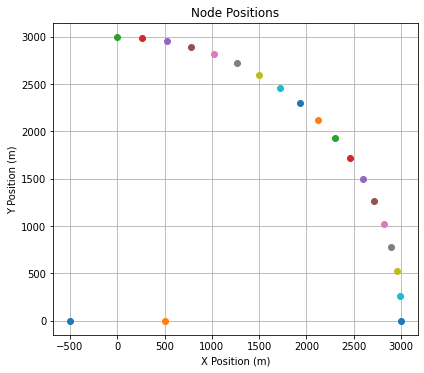

In [5]:
plt.figure(figsize=(6,6))

ax = plt.gca()

ax.set_title('Node Positions')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')

a.plot_point(ax)
b.plot_point(ax)

for node in targets:
    node.plot_point(ax)

ax.grid()
ax.set_aspect('equal')
plt.tight_layout()

In [6]:
ab_time = a.delay(b)

# Waveform Examples and AoA Result

TDoA: 2.5 μS
AoA: 48.55° expected 50°


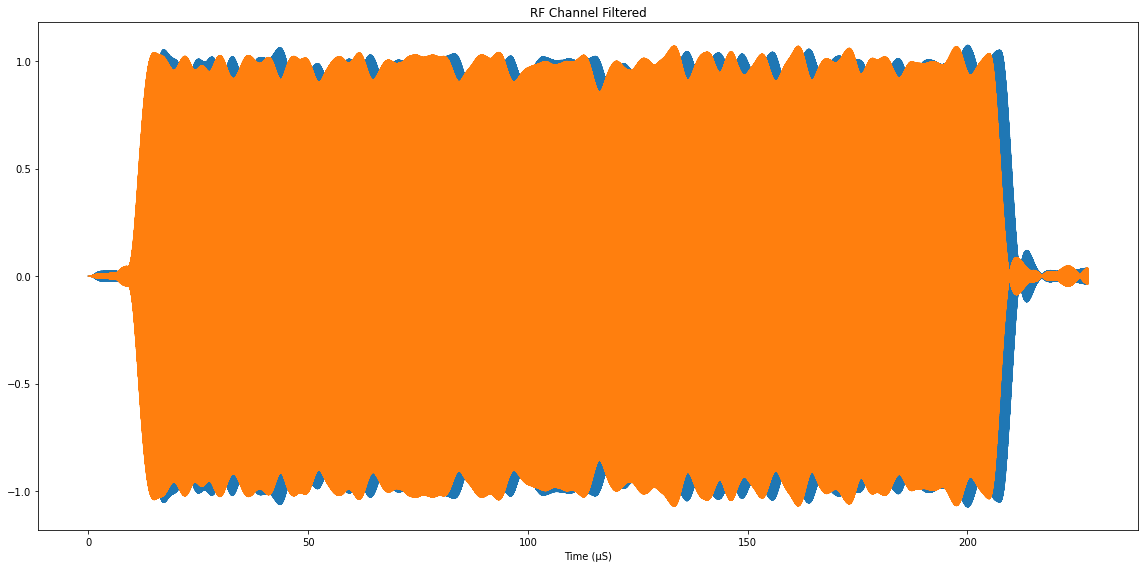

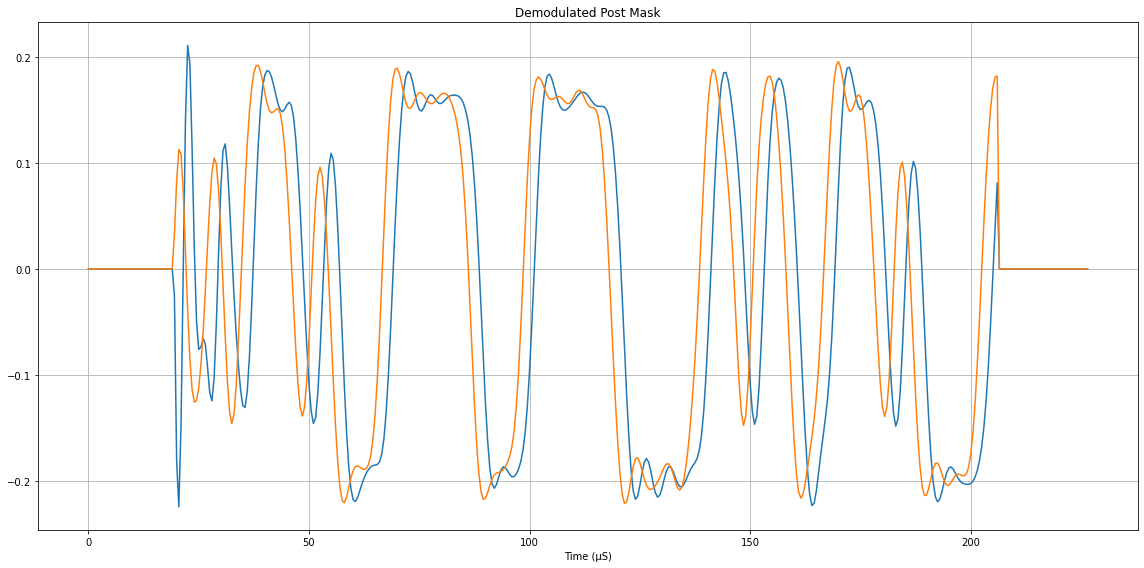

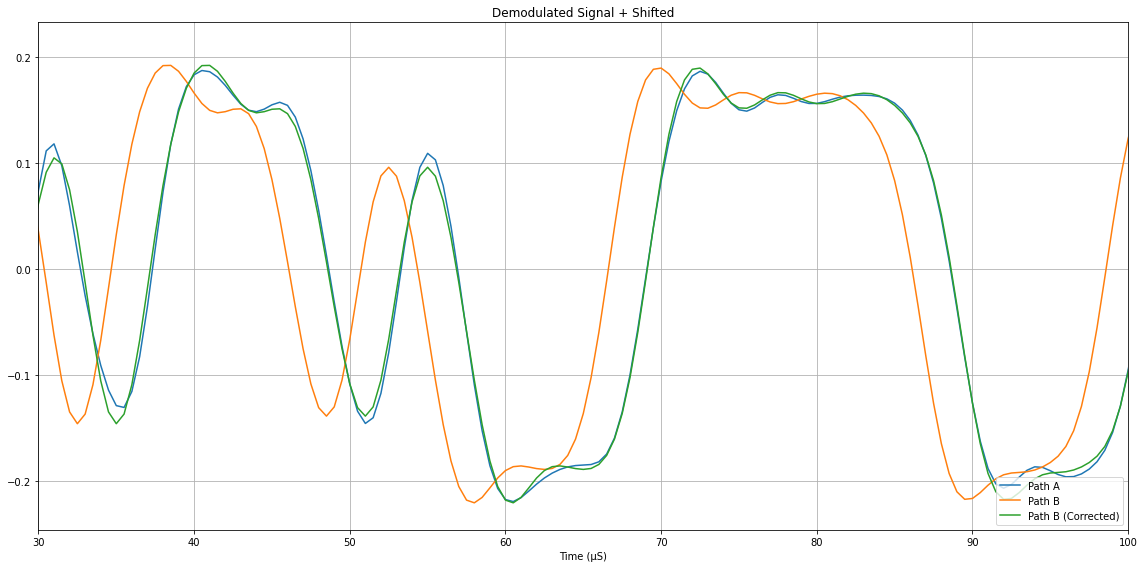

In [7]:
target_idx = 10

TDoA = calculate_TDoA(targets[target_idx],
                      a, b,
                      do_plot=True,
                      debug=['plot_rf', 'plot_demod_post', 'plot_demod_x'])
print(f'TDoA: {TDoA*1e6:.1f} μS')
print(f'AoA: {np.degrees(calculate_AoA(TDoA, ab_time)):.2f}° expected {target_idx*5:.0f}°')

# Long Range Angle of Arrivale Estimation

In [8]:
TDoAs = []
for target in targets:
    TDoA = calculate_TDoA(
        target,
        a, b,
        fs_ds=5e6
    )
    TDoAs.append(TDoA)

In [9]:
table  = '| True Angle | Estimated Angle |\n'
table += '|:----------:|:---------------:|\n'

for target, TDoA in zip(targets, TDoAs):    
    table += f'| {target.name} | {np.degrees(calculate_AoA(TDoA, ab_time)):.2f}° |\n'

display(Markdown(table))

| True Angle | Estimated Angle |
|:----------:|:---------------:|
| 0° | 0.00° |
| 5° | 3.44° |
| 10° | 10.36° |
| 15° | 17.45° |
| 20° | 21.08° |
| 25° | 24.82° |
| 30° | 28.66° |
| 35° | 32.66° |
| 40° | 41.27° |
| 45° | 46.01° |
| 50° | 51.21° |
| 55° | 57.08° |
| 60° | 57.08° |
| 65° | 64.08° |
| 70° | 64.08° |
| 75° | 73.60° |
| 80° | 73.60° |
| 85° | 73.60° |
| 90° | 73.60° |


Angle of Arrival accuracy suffers near 90 degrees as sensitivity to errors in TDoA increase due to arcsin.

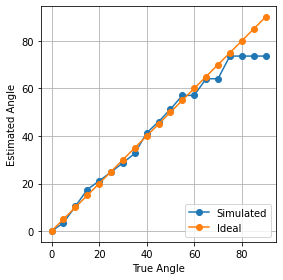

In [10]:
plt.figure()
ax = plt.gca()
ax.plot(np.degrees(angles), np.degrees(calculate_AoA(TDoAs, ab_time)), 'o-', label='Simulated')
ax.plot(np.degrees(angles), np.degrees(angles), 'o-', label='Ideal')
ax.set_aspect('equal')
ax.set_ylabel("Estimated Angle")
ax.set_xlabel("True Angle")
ax.legend(loc='lower right')
ax.grid()
plt.tight_layout()

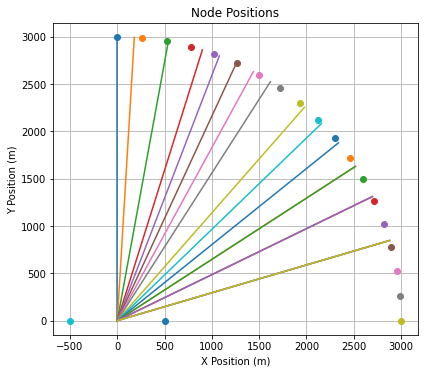

In [11]:
plt.figure(figsize=(6,6))

ax = plt.gca()

ax.set_title('Node Positions')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')

for node in targets:
    node.plot_point(ax)

r = np.linspace(0, 3000, 2)
for i, TDoA in enumerate(TDoAs):
    ang = calculate_AoA(TDoA, ab_time)
    ax.plot(r*np.sin(ang), r*np.cos(ang), color=colors[i%len(colors)])

a.plot_point(ax)
b.plot_point(ax)
    
ax.grid()
ax.set_aspect('equal')
plt.tight_layout()

# Long Range Cross Correlation Position Estimates from 3 Nodes in Triangle

In [12]:
radius = 3000
angles = np.linspace(0, np.pi / 2, 19)
targets = []
for ang in angles:
    targets.append(Node(f'{np.degrees(ang):0.0f}°', radius*np.sin(ang), radius*np.cos(ang)))

a = Node('A', -500, -500)
b = Node('B',  500, -500)
c = Node('C',    0,  500)
d = Node('D',  125,  200)

nodes = [a, b, c, d]

In [13]:
pairs = [(a,b), (b,c), (a,c)]
TDoAs = []

for pair in pairs:

    TDoA = calculate_TDoA(
        d,
        pair[0], pair[1],
        fs_ds=2e6
    )

    TDoAs.append(TDoA)
    
    print(f'TDoA ({pair[0].name}, {pair[1].name}): {TDoA*1e6:.1f} μS')

TDoA (A, B): 0.5 μS
TDoA (B, C): 1.5 μS
TDoA (A, C): 2.0 μS


#### Error at True position

In [14]:
table  = '| True (μS) | Measured (μS) | Error (μS) |\n'
table += '|:---------:|:-------------:|:----------:|\n'
for pair, measured_TDoA in zip(pairs, TDoAs):

    n = Node('n', 125, 200)
    true_TDoA = np.abs(pair[0].delay(n) - pair[1].delay(n))
    error = np.abs(true_TDoA - measured_TDoA)

    table += f'| {true_TDoA*1e6:9.2f} | {measured_TDoA*1e6:13.2f} | {error*1e6:10.2f} |\n'

display(Markdown(table))

| True (μS) | Measured (μS) | Error (μS) |
|:---------:|:-------------:|:----------:|
|      0.48 |          0.50 |       0.02 |
|      1.56 |          1.50 |       0.06 |
|      2.05 |          2.00 |       0.05 |


In [15]:
delta = 5
x = y = np.arange(-510.0, 510.0 + delta, delta)
X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)

for i in range(len(x)):
    for j in range(len(y)):

        x2 = X[i, j]
        y2 = Y[i, j]
        
        sum_error = 0

        for pair, measured_TDoA in zip(pairs, TDoAs):

            n = Node('n', x2, y2)
            true_TDoA = np.abs(pair[0].delay(n) - pair[1].delay(n))
            error = np.abs(true_TDoA - measured_TDoA)

            sum_error += error

        Z[i, j] = sum_error

min_error_idx = np.argmin(Z)
xmin = X.flatten()[min_error_idx]
ymin = Y.flatten()[min_error_idx]

d_est = Node('D (Estimated)', xmin, ymin)

Error: 11.2 m


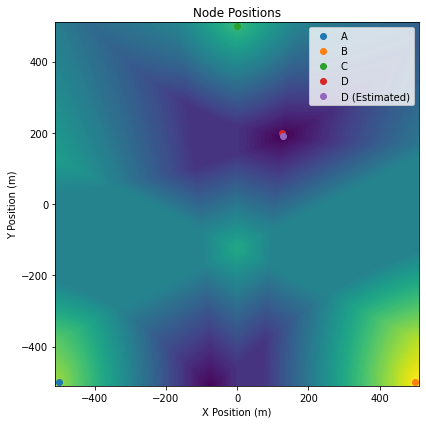

In [16]:
plt.figure(figsize=(6,6))

print(f'Error: {d.euclidian(d_est):.1f} m')

ax = plt.gca()

ax.set_title('Node Positions')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')

im = ax.contourf(x, y, Z, levels=100, cmap=plt.get_cmap('viridis'))

for node in nodes:
    node.plot_point(ax)

d_est.plot_point(ax)
    
ax.set_aspect('equal')
ax.legend(loc='upper right')
plt.tight_layout()